# Brain Tumors MRI Images Segmentation CNN(AE)+LSTM



## Introduction

The goal of this work is to reimplement the CNN based LSTM,  a model which takes in the same time the spatial and temporal information. This design aims to improve the performance of 3D Brain tumors MRI images segementation. In particular, a set of brain slicing image could be considered as a sereis of moving image.

## Method


This experiments compare the result of segementation with Autoencoder, CNNbased LSTM, and its variation, Bidirectional CNN-LSTM. As a basical design, the model is composed of 3 part:
    1. CNN based encoder,
    2. LSTM,
    3. CNN based decoder.
    
The model takes a series of MRI images of type T2 as input, and gives the shape of tumors on a background. The loss function is MSE for comparing two images. 

The set are split into 2 parts, 70% for training and 30% for test.



## Result

The current result is not clear that the LSTM based model could perform better than autoencoder. It needs more experiments for further proofs.

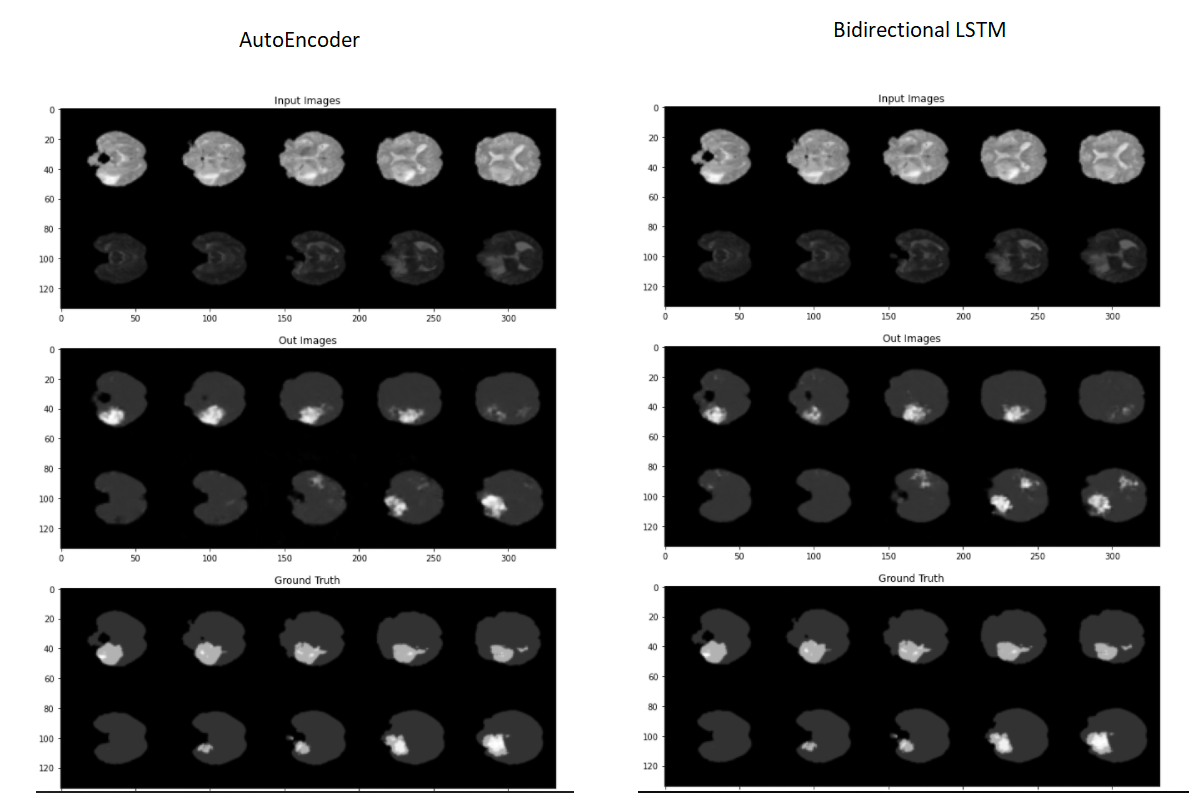

# Codes

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Read Images and Create Dataset

In [253]:
# Root directory for dataset
dataroot_T2 = "./BraTS2015_Medium/T2/train"
dataroot_OT = "./BraTS2015_Medium/OT/train"
dataroot_OT_Back = "./BraTS2015_Medium/OT_BACKGROUND/train"

dataroot_T2_test = "./BraTS2015_Medium/T2/test"
dataroot_OT_test = "./BraTS2015_Medium/OT/test"
dataroot_OT_Back_test = "./BraTS2015_Medium/OT_BACKGROUND/test"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 25

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

#   size of fixed noise
fixed_noise_size = 25

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
lstm_step_size = 5
hidden_layer_size = 100

In [98]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset_T2 = dset.ImageFolder(root=dataroot_T2,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_OT = dset.ImageFolder(root=dataroot_OT,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_OT_Back = dset.ImageFolder(root=dataroot_OT_Back,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataset_OT_Back_test = dset.ImageFolder(root=dataroot_OT_Back_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataset_T2_test = dset.ImageFolder(root=dataroot_T2_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

In [99]:
14 % 176 % 18

14

In [100]:
class CustomerDataset(Dataset):

    def __init__(self, ds1, ds2, lstm_step=10, series_lenth=176, series_width=18):
        super(CustomerDataset, self).__init__()
        self.ds1 = [ds1[index][0] for index in range(len(ds1))]
        self.ds2 = [ds2[index][0] for index in range(len(ds2))]
        self.lstm_step = lstm_step
        
        self.series_lenth=series_lenth # the number of the series
        self.series_width=series_width # the number of the images in a series
        
        self.padding = torch.zeros(ds1[0][0].shape)
        
    def __len__(self):
        return len(self.ds1)

    def __getitem__(self, index): 
        # for index bigger than series_width - lstm_step, 13, padding 0 instead of index the image
        # for example, the image at index 1000, means the  1000 % 18 = 10
        image_index_in_series =  index % self.series_width # the index within its series of images
        series_size = min(self.series_width - image_index_in_series, self.lstm_step)
        padding_size = self.lstm_step - series_size
        #print(index, image_index_in_series, series_size, padding_size)
        
        series_1 = torch.cat([self.ds1[index+i] for i in range(series_size)] + [self.padding for i in range(padding_size)],dim=0)
        series_2 = torch.cat([self.ds2[index+i] for i in range(series_size)] + [self.padding for i in range(padding_size)],dim=0)
        
        return series_1, series_2


In [101]:
ds =  CustomerDataset(dataset_T2, dataset_OT_Back, lstm_step=lstm_step_size)

In [102]:
len(ds)

3168

In [103]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size,pin_memory=True,timeout=0,
                                         shuffle=True, num_workers=workers)

In [104]:
ds[26][0]

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1

for i, (ds1, ds2),  in enumerate(dataloader):  
    print(i, len(ds1), len(ds2))

2
torch.Size([25, 5, 64, 64])
torch.Size([25, 5, 64, 64])
torch.Size([125, 1, 64, 64])
tensor(-0.6000)


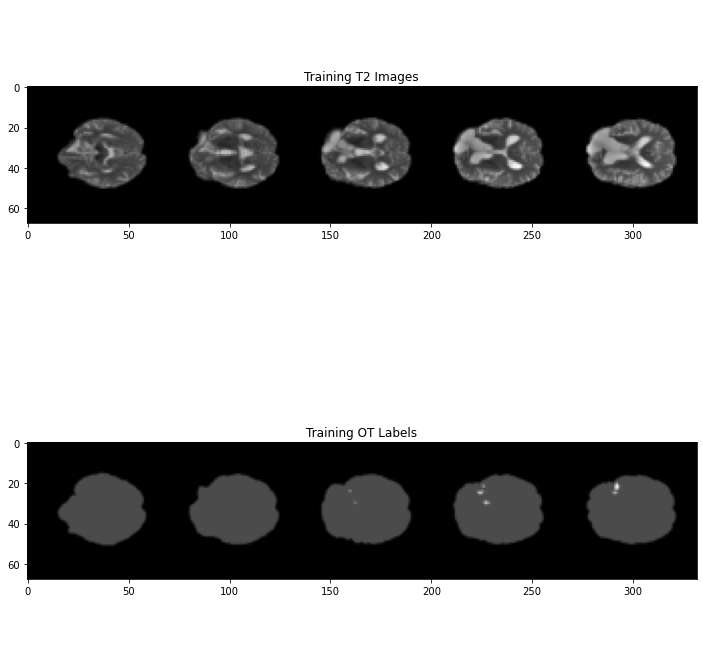

In [105]:

# Plot some training images
real_batch = next(iter(dataloader))
print(len(real_batch))
series_1 = real_batch[0]
series_2 = real_batch[1]
print(series_1.shape)
print(series_2.shape)
print(series_1.view(-1,nc,image_size,image_size).shape)
print(series_2[0,0].max())

fig=plt.figure(figsize=(12,12))
plt.axis("off")

 
fig.add_subplot(2, 1, 1)
plt.title("Training T2 Images")
plt.imshow(np.transpose(vutils.make_grid(series_1[0].view(-1,nc,image_size,image_size).to(device), padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

  
fig.add_subplot(2, 1, 2)
plt.title("Training OT Labels")
plt.imshow(np.transpose(vutils.make_grid(series_2[0].view(-1,nc,image_size,image_size).to(device), padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

plt.show()

## Create the Model

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
torch.zeros(1,1,100).to(device)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')

In [261]:
class LSTM(nn.Module):
    def __init__(self, ngpu, input_size=1, step_size=5,  hidden_layer_size=100, stack_nb=1, output_size=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.ngpu = ngpu
        self.hidden_layer_size = hidden_layer_size
        self.step_size = step_size
        self.stack_nb = stack_nb
        self.lstm = nn.LSTM(input_size, hidden_layer_size, bidirectional=bidirectional)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        #hidden and cell units
        self.hidden_cell = (torch.zeros(stack_nb, step_size, hidden_layer_size).to(device),
                            torch.zeros(stack_nb, step_size, hidden_layer_size).to(device))
         

    def forward(self, input_seq): 
        self.hidden_cell_to_zero()
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1, self.hidden_layer_size)) 
        return predictions
    
    def hidden_cell_to_zero(self):
        self.hidden_cell = (torch.zeros(self.stack_nb, self.step_size, self.hidden_layer_size).to(device),
                            torch.zeros(self.stack_nb, self.step_size, self.hidden_layer_size).to(device))

In [262]:
model_LSTM = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, hidden_layer_size=hidden_layer_size, output_size=nz, bidirectional=False).to(device)
loss_mse = nn.MSELoss() #ssim
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=lr)
model_LSTM.apply(weights_init)

LSTM(
  (lstm): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
)

In [263]:
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu  
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, nz, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
         
        

    def forward(self, input):
        return self.main(input)

In [264]:

class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [265]:
# Create the Discriminator
netEncoder = Encoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netEncoder = nn.DataParallel(netEncoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netEncoder.apply(weights_init)

# Print the model
print(netEncoder)

Encoder(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [266]:
# Create the Discriminator
netDecoder = Decoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDecoder = nn.DataParallel(netDecoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netDecoder.apply(weights_init)

# Print the model
print(netDecoder)

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


class ConvLSTM(nn.Module):
    def __init__(self, ngpu, input_size=nz, step_size=lstm_step_size, hidden_layer_size=hidden_layer_size, output_size=nz, bidirectional=False):
        super(ConvLSTM, self).__init__()
        self.ngpu = ngpu
        self.encoder = Encoder(ngpu)
        self.lstm = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, 
                hidden_layer_size=hidden_layer_size, output_size=nz, bidirectional=False)
        self.decoder = Decoder(ngpu)

    def forward(self, input):
        output = self.encoder(input.view(-1,1,input.shape[2], input.shape[3]))
        output = self.lstm(output.view(b_size, -1, nz))
        output = self.decoder(output.view(-1, nz, 1, 1))
        
        return output.view(input.shape)

# Create the Discriminator
netConvLSTM = ConvLSTM(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netConvLSTM = nn.DataParallel(netConvLSTM, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netConvLSTM.encoder.apply(weights_init)
netConvLSTM.lstm.apply(weights_init)
netConvLSTM.decoder.apply(weights_init)

# Print the model
print(netConvLSTM)

In [267]:
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(fixed_noise_size, nz, 1, 1, device=device)

#  the progression of the generator
selected_index = np.random.randint(len(ds), size=fixed_noise_size)
fixed_ot_image = torch.stack([ds[i][0][1] for i in selected_index]).to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerDecoder = optim.Adam(netDecoder.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerEncoder = optim.Adam(netEncoder.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerConvLSTM= optim.Adam(netConvLSTM.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

(torch.ones(3,3) *0,torch.ones(3,3)*0)*0


#input feature size, hidden/cell layer size, lstm stack size
rnn = nn.LSTM(7, 5, 3)

#batch size/output size, hidden/cell step lenth(t), feature size
input = torch.randn(5, 2, 7)

#lstm stack size, hidden/cell step lenth(t), hidden/cell layer size
h0 = torch.randn(3, 2, 5)
c0 = torch.randn(3, 2, 5)

output, (hn, cn) = rnn(input, (h0, c0))

#output: batch size, hidden/cell step lenth(t), hidden/cell layer size
print(output.shape)

#lstm stack size, hidden/cell step lenth(t), hidden/cell layer size
print(hn.shape)

#lstm stack size, hidden/cell step lenth(t), hidden/cell layer size
print(cn.shape)

#input feature size, hidden/cell layer size, lstm stack size
#batch, seq, feature
rnn = nn.LSTM(11, 5, 7, batch_first=True)

#seq_len, batch, input_size
input = torch.randn(5, 11, 11)

#lstm stack size, hidden/cell step lenth(t), hidden/cell layer size
h0 = torch.randn(7, 5, 5)
c0 = torch.randn(7, 5, 5)

output, (hn, cn) = rnn(input, (h0, c0))

#output: (batch, seq, feature).
print(output.shape)

#lstm stack size, hidden/cell step lenth(t), hidden/cell layer size
print(hn.shape)

#lstm stack size, hidden/cell step lenth(t), hidden/cell layer size
print(cn.shape)

In [268]:
torch.autograd.set_detect_anomaly(True)

In [269]:
# Training Loop

# Lists to keep track of progress
img_list = [] 
losses = []

iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        real_cpu = data_t2.to(device)
        mask_cpu = data_ot.to(device)
        #print("real_cpu.shape", real_cpu.shape)
        b_size = real_cpu.size(0)
        
        netEncoder.zero_grad()
        netDecoder.zero_grad()
        model_LSTM.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        representation = netEncoder(real_cpu.view(-1, 1, real_cpu.shape[2], real_cpu.shape[3])).view(b_size, -1, 1, 1)
        #print(representation.shape)
        #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

        #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
        #                          model_LSTM.hidden_cell[1] * 0)
        
        output_lstm = model_LSTM(representation.view(b_size, -1, nz))
        #print("output_lstm.shape", output_lstm.shape)

        #output = netConvLSTM(real_cpu) 
        output = netDecoder(output_lstm.view(-1, nz,1,1)).view(real_cpu.shape)
        #print("output.shape", output.shape)

        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) * 50
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerDecoder.step()
        optimizer_LSTM.step()
        optimizerEncoder.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item(), D_x))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/100][0/127]	Loss: 37.9823	D(x): 37.9823
[0/100][50/127]	Loss: 4.1468	D(x): 4.1468
[0/100][100/127]	Loss: 1.8822	D(x): 1.8822
[1/100][0/127]	Loss: 1.2597	D(x): 1.2597
[1/100][50/127]	Loss: 1.2920	D(x): 1.2920
[1/100][100/127]	Loss: 0.7089	D(x): 0.7089
[2/100][0/127]	Loss: 0.6753	D(x): 0.6753
[2/100][50/127]	Loss: 0.9651	D(x): 0.9651
[2/100][100/127]	Loss: 0.8396	D(x): 0.8396
[3/100][0/127]	Loss: 0.7022	D(x): 0.7022
[3/100][50/127]	Loss: 0.5153	D(x): 0.5153
[3/100][100/127]	Loss: 0.5616	D(x): 0.5616
[4/100][0/127]	Loss: 0.4306	D(x): 0.4306
[4/100][50/127]	Loss: 0.4348	D(x): 0.4348
[4/100][100/127]	Loss: 0.3335	D(x): 0.3335
[5/100][0/127]	Loss: 0.4111	D(x): 0.4111
[5/100][50/127]	Loss: 0.4148	D(x): 0.4148
[5/100][100/127]	Loss: 0.4575	D(x): 0.4575
[6/100][0/127]	Loss: 0.3724	D(x): 0.3724
[6/100][50/127]	Loss: 0.3479	D(x): 0.3479
[6/100][100/127]	Loss: 0.3403	D(x): 0.3403
[7/100][0/127]	Loss: 0.2713	D(x): 0.2713
[7/100][50/127]	Loss: 0.2630	D(x): 0.2630
[7/100]

KeyboardInterrupt: 

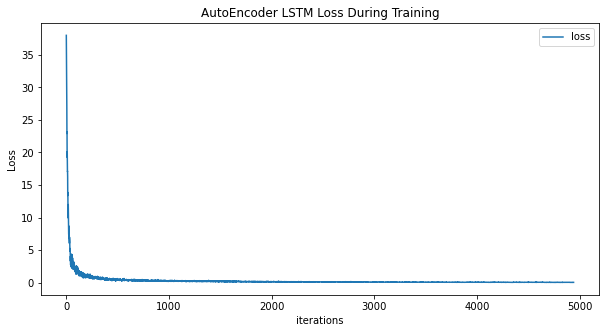

In [270]:
plt.figure(figsize=(10,5))
plt.title("AutoEncoder LSTM Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Check the result on Testing set 

In [271]:
ds_test =  CustomerDataset(dataset_T2_test, dataset_OT_Back_test, lstm_step=lstm_step_size)


In [276]:
size_test = 2
selected_index = np.random.randint(len(dataset_OT_Back_test), size=size_test)
fixed_T2_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device)

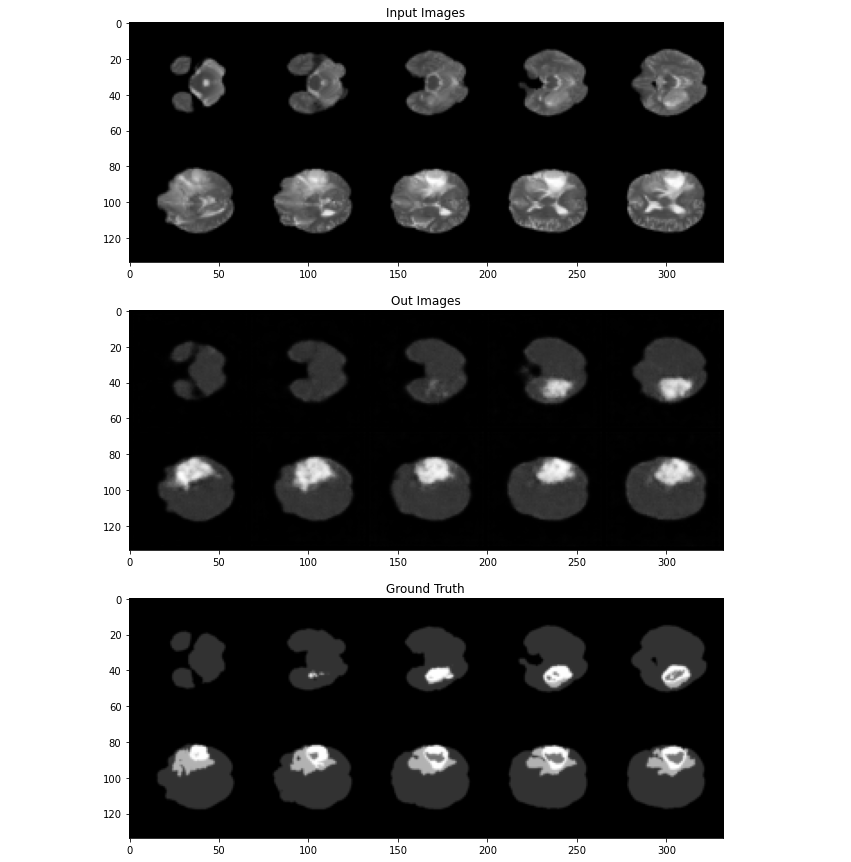

In [277]:
with torch.no_grad():
    real_cpu = fixed_T2_image
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu.view(-1, 1, real_cpu.shape[2], real_cpu.shape[3])).view(b_size,-1,1,1)  
    #print("output_lstm.shape", output_lstm.shape)
    #output = netDecoder(representation).view(real_cpu.shape)

    output_lstm = model_LSTM(representation.view(size_test, -1, nz))
    
    output = netDecoder(output_lstm.view(-1, nz,1,1)).view(real_cpu.shape)

    images_to_plot = torch.cat((real_cpu, output), dim=0).cpu()
    vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5)
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(3, 1, 1)
plt.title("Input Images")
img = np.transpose(vutils.make_grid(real_cpu.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)


fig.add_subplot(3, 1, 2)
plt.title("Out Images")
img = np.transpose(vutils.make_grid(output.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(3, 1, 3)
plt.title("Ground Truth")
img = np.transpose(vutils.make_grid(ground_truth.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()

## Comparison with Autoencoder

In [162]:
# Training Loop

# Lists to keep track of progress
img_list = [] 
losses = []

iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        real_cpu = data_t2.to(device)
        mask_cpu = data_ot.to(device)
        #print("real_cpu.shape", real_cpu.shape)
        b_size = real_cpu.size(0)
        
        netEncoder.zero_grad()
        netDecoder.zero_grad()
        model_LSTM.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        representation = netEncoder(real_cpu.view(-1, 1, real_cpu.shape[2], real_cpu.shape[3])).view(b_size, -1, 1, 1)
        #print(representation.shape)
        #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

        #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
        #                          model_LSTM.hidden_cell[1] * 0)
        
        #output_lstm = model_LSTM(representation.view(b_size, -1, nz))
        #print("output_lstm.shape", output_lstm.shape)

        #output = netConvLSTM(real_cpu) 
        #output = netDecoder(output_lstm.view(-1, nz,1,1)).view(real_cpu.shape)
        output = netDecoder(representation.view(-1, nz,1,1)).view(real_cpu.shape)
        #print("output.shape", output.shape)

        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) * 50
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerDecoder.step()
        optimizer_LSTM.step()
        optimizerEncoder.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item(), D_x))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/800][0/127]	Loss: 31.1349	D(x): 31.1349
[0/800][50/127]	Loss: 2.2601	D(x): 2.2601
[0/800][100/127]	Loss: 1.6022	D(x): 1.6022
[1/800][0/127]	Loss: 2.0677	D(x): 2.0677
[1/800][50/127]	Loss: 1.2077	D(x): 1.2077
[1/800][100/127]	Loss: 0.9560	D(x): 0.9560
[2/800][0/127]	Loss: 0.9841	D(x): 0.9841
[2/800][50/127]	Loss: 0.7749	D(x): 0.7749
[2/800][100/127]	Loss: 0.5203	D(x): 0.5203
[3/800][0/127]	Loss: 0.4344	D(x): 0.4344
[3/800][50/127]	Loss: 0.4740	D(x): 0.4740
[3/800][100/127]	Loss: 0.4980	D(x): 0.4980
[4/800][0/127]	Loss: 0.4459	D(x): 0.4459
[4/800][50/127]	Loss: 0.4267	D(x): 0.4267
[4/800][100/127]	Loss: 0.4138	D(x): 0.4138
[5/800][0/127]	Loss: 0.3942	D(x): 0.3942
[5/800][50/127]	Loss: 0.4436	D(x): 0.4436
[5/800][100/127]	Loss: 0.2947	D(x): 0.2947
[6/800][0/127]	Loss: 0.2135	D(x): 0.2135
[6/800][50/127]	Loss: 0.3310	D(x): 0.3310
[6/800][100/127]	Loss: 0.2473	D(x): 0.2473
[7/800][0/127]	Loss: 0.2368	D(x): 0.2368
[7/800][50/127]	Loss: 0.2144	D(x): 0.2144
[7/800]

[63/800][100/127]	Loss: 0.0298	D(x): 0.0298
[64/800][0/127]	Loss: 0.0289	D(x): 0.0289
[64/800][50/127]	Loss: 0.0331	D(x): 0.0331
[64/800][100/127]	Loss: 0.0237	D(x): 0.0237
[65/800][0/127]	Loss: 0.0244	D(x): 0.0244
[65/800][50/127]	Loss: 0.0319	D(x): 0.0319
[65/800][100/127]	Loss: 0.0294	D(x): 0.0294
[66/800][0/127]	Loss: 0.0271	D(x): 0.0271
[66/800][50/127]	Loss: 0.0364	D(x): 0.0364
[66/800][100/127]	Loss: 0.0334	D(x): 0.0334
[67/800][0/127]	Loss: 0.0365	D(x): 0.0365
[67/800][50/127]	Loss: 0.0284	D(x): 0.0284
[67/800][100/127]	Loss: 0.0240	D(x): 0.0240
[68/800][0/127]	Loss: 0.0258	D(x): 0.0258
[68/800][50/127]	Loss: 0.0252	D(x): 0.0252
[68/800][100/127]	Loss: 0.0259	D(x): 0.0259
[69/800][0/127]	Loss: 0.0312	D(x): 0.0312
[69/800][50/127]	Loss: 0.0373	D(x): 0.0373
[69/800][100/127]	Loss: 0.0250	D(x): 0.0250
[70/800][0/127]	Loss: 0.0396	D(x): 0.0396
[70/800][50/127]	Loss: 0.0321	D(x): 0.0321
[70/800][100/127]	Loss: 0.0610	D(x): 0.0610
[71/800][0/127]	Loss: 0.0379	D(x): 0.0379
[71/800][50

KeyboardInterrupt: 

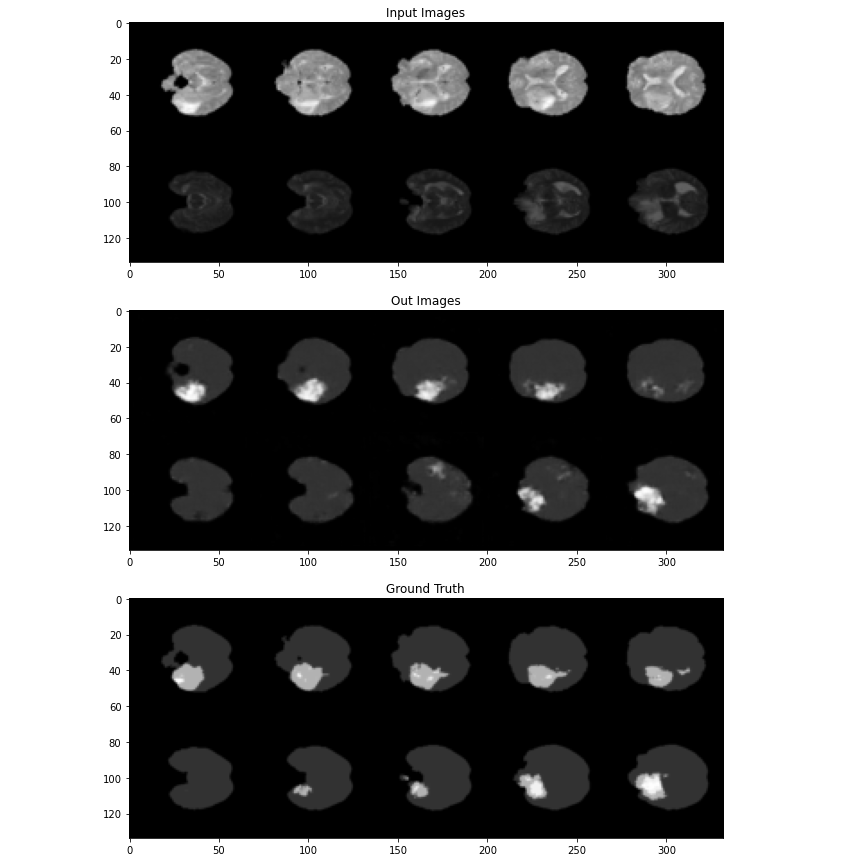

In [165]:
with torch.no_grad():
    real_cpu = fixed_T2_image
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu.view(-1, 1, real_cpu.shape[2], real_cpu.shape[3])).view(b_size,-1,1,1)  
    #print("output_lstm.shape", output_lstm.shape)
    #output = netDecoder(representation).view(real_cpu.shape)

    #output_lstm = model_LSTM(representation.view(size_test, -1, nz))
    
    output = netDecoder(representation.view(-1, nz,1,1)).view(real_cpu.shape)

    images_to_plot = torch.cat((real_cpu, output), dim=0).cpu()
    vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5)
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(3, 1, 1)
plt.title("Input Images")
img = np.transpose(vutils.make_grid(real_cpu.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)


fig.add_subplot(3, 1, 2)
plt.title("Out Images")
img = np.transpose(vutils.make_grid(output.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(3, 1, 3)
plt.title("Ground Truth")
img = np.transpose(vutils.make_grid(ground_truth.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()

## Comparison with bi-directional lstm

In [255]:
class LSTM(nn.Module):
    def __init__(self, ngpu, input_size=1, step_size=5,  hidden_layer_size=100, stack_nb=1, output_size=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.ngpu = ngpu
        self.hidden_layer_size = hidden_layer_size
        self.step_size = step_size
        self.stack_nb = stack_nb
        self.lstm = nn.LSTM(input_size, hidden_layer_size, bidirectional=bidirectional)

        
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
            
        self.linear = nn.Linear(hidden_layer_size*self.num_directions, output_size)
        
        #hidden and cell units
        self.hidden_cell = (torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device),
                            torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device))
         

    def forward(self, input_seq): 
        self.hidden_cell_to_zero()
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        #print("lstm_out.shape", lstm_out.shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1, self.hidden_layer_size * self.num_directions))
        #print("predictions.shape", predictions.shape)
        return predictions
    
    def hidden_cell_to_zero(self):
        self.hidden_cell = (torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device),
                            torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device))

In [256]:
model_LSTM = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, hidden_layer_size=hidden_layer_size, output_size=nz, bidirectional=True).to(device)
loss_mse = nn.MSELoss() #ssim
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=lr)
model_LSTM.apply(weights_init)

LSTM(
  (lstm): LSTM(100, 100, bidirectional=True)
  (linear): Linear(in_features=200, out_features=100, bias=True)
)

In [259]:
# Training Loop

# Lists to keep track of progress
img_list = [] 
losses = []

iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        real_cpu = data_t2.to(device)
        mask_cpu = data_ot.to(device)
        #print("real_cpu.shape", real_cpu.shape)
        b_size = real_cpu.size(0)
        
        netEncoder.zero_grad()
        netDecoder.zero_grad()
        model_LSTM.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        representation = netEncoder(real_cpu.view(-1, 1, real_cpu.shape[2], real_cpu.shape[3])).view(b_size, -1, 1, 1)
        #print(representation.shape)
        #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

        #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
        #                          model_LSTM.hidden_cell[1] * 0)
        
        output_lstm = model_LSTM(representation.view(b_size, -1, nz))
        #print("output_lstm.shape", output_lstm.shape)
        #print("output_lstm.view(-1, nz,1,1).shape", output_lstm.view(-1, nz,1,1).shape)

        #output = netConvLSTM(real_cpu) 
        output = netDecoder(output_lstm.view(-1, nz,1,1)).view(real_cpu.shape)
        #print("output.shape", output.shape)

        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) * 50
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerDecoder.step()
        optimizer_LSTM.step()
        optimizerEncoder.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item(), D_x))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/100][0/127]	Loss: 0.0757	D(x): 0.0757
[0/100][50/127]	Loss: 0.0898	D(x): 0.0898
[0/100][100/127]	Loss: 0.1056	D(x): 0.1056
[1/100][0/127]	Loss: 0.0909	D(x): 0.0909
[1/100][50/127]	Loss: 0.0871	D(x): 0.0871
[1/100][100/127]	Loss: 0.0897	D(x): 0.0897
[2/100][0/127]	Loss: 0.1050	D(x): 0.1050
[2/100][50/127]	Loss: 0.0653	D(x): 0.0653
[2/100][100/127]	Loss: 0.0946	D(x): 0.0946
[3/100][0/127]	Loss: 0.0839	D(x): 0.0839
[3/100][50/127]	Loss: 0.0819	D(x): 0.0819
[3/100][100/127]	Loss: 0.0878	D(x): 0.0878
[4/100][0/127]	Loss: 0.0982	D(x): 0.0982
[4/100][50/127]	Loss: 0.0999	D(x): 0.0999
[4/100][100/127]	Loss: 0.0726	D(x): 0.0726
[5/100][0/127]	Loss: 0.0690	D(x): 0.0690
[5/100][50/127]	Loss: 0.0679	D(x): 0.0679
[5/100][100/127]	Loss: 0.0649	D(x): 0.0649
[6/100][0/127]	Loss: 0.0964	D(x): 0.0964
[6/100][50/127]	Loss: 0.0817	D(x): 0.0817
[6/100][100/127]	Loss: 0.0702	D(x): 0.0702
[7/100][0/127]	Loss: 0.0894	D(x): 0.0894
[7/100][50/127]	Loss: 0.0688	D(x): 0.0688
[7/100][1

[63/100][100/127]	Loss: 0.0273	D(x): 0.0273
[64/100][0/127]	Loss: 0.0373	D(x): 0.0373
[64/100][50/127]	Loss: 0.0288	D(x): 0.0288
[64/100][100/127]	Loss: 0.0258	D(x): 0.0258
[65/100][0/127]	Loss: 0.0328	D(x): 0.0328
[65/100][50/127]	Loss: 0.0256	D(x): 0.0256
[65/100][100/127]	Loss: 0.0322	D(x): 0.0322
[66/100][0/127]	Loss: 0.0385	D(x): 0.0385
[66/100][50/127]	Loss: 0.0279	D(x): 0.0279
[66/100][100/127]	Loss: 0.0235	D(x): 0.0235
[67/100][0/127]	Loss: 0.0255	D(x): 0.0255
[67/100][50/127]	Loss: 0.0189	D(x): 0.0189
[67/100][100/127]	Loss: 0.0207	D(x): 0.0207
[68/100][0/127]	Loss: 0.0304	D(x): 0.0304
[68/100][50/127]	Loss: 0.0318	D(x): 0.0318
[68/100][100/127]	Loss: 0.0221	D(x): 0.0221
[69/100][0/127]	Loss: 0.0387	D(x): 0.0387
[69/100][50/127]	Loss: 0.0312	D(x): 0.0312
[69/100][100/127]	Loss: 0.0320	D(x): 0.0320
[70/100][0/127]	Loss: 0.0195	D(x): 0.0195
[70/100][50/127]	Loss: 0.0275	D(x): 0.0275
[70/100][100/127]	Loss: 0.0260	D(x): 0.0260
[71/100][0/127]	Loss: 0.0270	D(x): 0.0270
[71/100][50

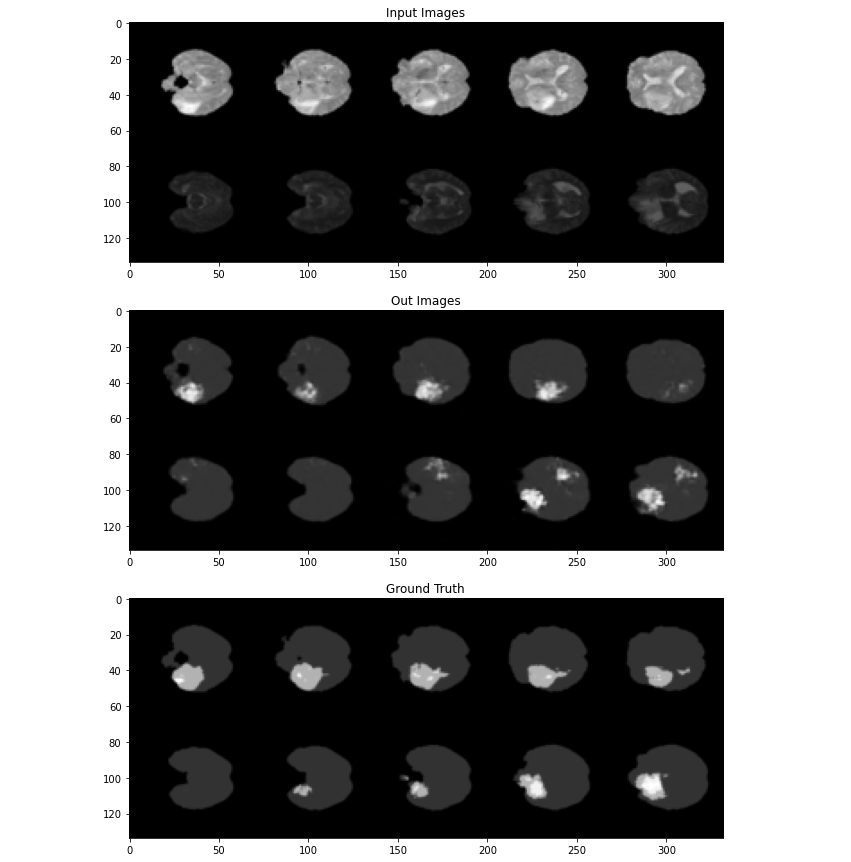

In [260]:
with torch.no_grad():
    real_cpu = fixed_T2_image
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0) 

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu.view(-1, 1, real_cpu.shape[2], real_cpu.shape[3])).view(b_size,-1,1,1)  
    #print("output_lstm.shape", output_lstm.shape)
    #output = netDecoder(representation).view(real_cpu.shape)

    output_lstm = model_LSTM(representation.view(size_test, -1, nz))
    
    output = netDecoder(output_lstm.view(-1, nz,1,1)).view(real_cpu.shape) 

    images_to_plot = torch.cat((real_cpu, output), dim=0).cpu()
    vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5)
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(3, 1, 1)
plt.title("Input Images")
img = np.transpose(vutils.make_grid(real_cpu.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)


fig.add_subplot(3, 1, 2)
plt.title("Out Images")
img = np.transpose(vutils.make_grid(output.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(3, 1, 3)
plt.title("Ground Truth")
img = np.transpose(vutils.make_grid(ground_truth.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()